# KerasCV로 CutMix, MixUp 및 RandAugment 이미지 보강

**저자:** [lukewood](https://twitter.com/luke_wood_ml)  
**생성일:** 2022/04/08  
**최종편집일:** 2022/04/08  
**설명:** KerasCV를 사용하면 CutMix, MixUp, RandAugment 등을 통해 이미지를 보강할 수 있습니다.

## 개요

KerasCV를 사용하면, 이미지 분류 및 객체 감지 작업을 위한,
최첨단 산업 등급 데이터 보강 파이프라인을 쉽게 조립할 수 있습니다.
KerasCV는 일반적인 데이터 보강 기술을 구현하는 광범위한 전처리 레이어를 제공합니다.

아마도 가장 유용한 레이어 중 세 가지는
[`keras_cv.layers.CutMix`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/layers/augmentation/cut_mix#cutmix-class),
[`keras_cv.layers.MixUp`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/layers/augmentation/mix_up#mixup-class),
[`keras_cv.layers.RandAugment`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/layers/augmentation/rand_augment#randaugment-class)일 것입니다.
이러한 레이어는 거의 모든 최첨단 이미지 분류 파이프라인에서 사용됩니다.

이 가이드에서는 이미지 분류 작업을 위한,
자체 데이터 보강 파이프라인으로 이러한 레이어를 구성하는 방법을 보여줍니다.
이 가이드에서는 KerasCV 데이터 보강 파이프라인을 커스터마이즈하는 프로세스도 안내합니다.

## Import & 셋업

KerasCV는 Keras 3을 사용하여 TensorFlow, PyTorch 또는 Jax 중 하나와 함께 작업합니다.
아래 가이드에서는 `jax` 백엔드를 사용합니다.
이 가이드는 변경 사항 없이 TensorFlow 또는 PyTorch 백엔드에서 실행되므로,
아래의 `KERAS_BACKEND`를 업데이트하기만 하면 됩니다.

In [1]:
# 이 노트북은 Keras cv가 설치되어 있다는 가정 하에 진행됩니다.
# 이 노트북은 Keras 3이 설치되어 있다는 가정 하에 진행됩니다.
#
# !pip install -q --upgrade keras-cv
# !pip install -q --upgrade keras  # Upgrade to Keras 3.

먼저 필요한 모든 패키지를 import 합니다.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import matplotlib.pyplot as plt

# [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) 및
# 해당 전처리 맵 함수에 대한 tensorflow import
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import keras_cv

## 데이터 로딩

이 가이드에서는 데모 목적으로,
[102 Category Flower Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/)을 사용합니다.

시작하려면, 먼저 데이터 세트를 로드합니다.

In [4]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
tfds.enable_progress_bar()
data, dataset_info = tfds.load("oxford_flowers102", with_info=True, as_supervised=True)
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
val_steps_per_epoch = dataset_info.splits["test"].num_examples // BATCH_SIZE

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteCKWUVB/oxford_flowers102-train.tfrecord*…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteCKWUVB/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteCKWUVB/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


다음으로, 이미지를 constant 크기인 `(224, 224)`로 조정하고, 레이블을 원핫 인코딩합니다.
[`keras_cv.layers.CutMix`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/layers/augmentation/cut_mix#cutmix-class)와 [`keras_cv.layers.MixUp`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/layers/augmentation/mix_up#mixup-class)은 대상이 원핫 인코딩되기를 기대합니다.
이는 희소(sparse) 레이블 표현으로는 불가능한 방식으로, 대상의 값을 수정하기 때문입니다.

In [5]:
IMAGE_SIZE = (224, 224)
num_classes = dataset_info.features["label"].num_classes


def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, num_classes)
    return {"images": image, "labels": label}


def prepare_dataset(dataset, split):
    if split == "train":
        return (
            dataset.shuffle(10 * BATCH_SIZE)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
        )
    if split == "test":
        return dataset.map(to_dict, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)


def load_dataset(split="train"):
    dataset = data[split]
    return prepare_dataset(dataset, split)


train_dataset = load_dataset()

데이터 세트에서 몇 가지 샘플을 살펴보겠습니다.

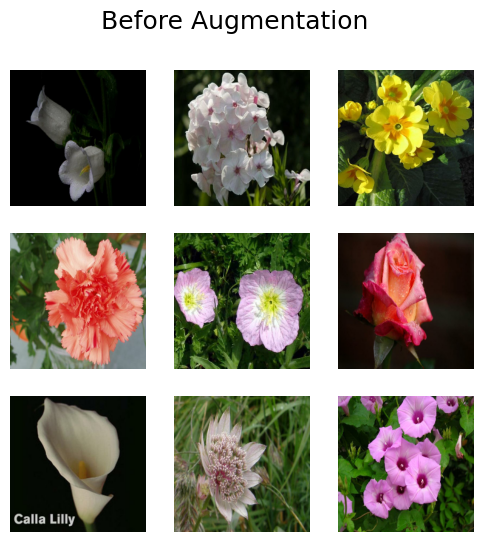

In [6]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()


visualize_dataset(train_dataset, title="Before Augmentation")

좋아요! 이제 보강 단계로 넘어갈 수 있습니다.

## RandAugment

[RandAugment](https://arxiv.org/abs/1909.13719)는 수많은 데이터 세트에서,
향상된 이미지 분류 결과를 제공하는 것으로 나타났습니다.
이미지에 표준 보강 세트를 수행합니다.

KerasCV에서 RandAugment를 사용하려면, 몇 가지 값을 제공해야 합니다.

* `value_range`는 이미지에서 다루는 값의 범위를 설명합니다.
* `magnitude`는 0과 1 사이의 값으로, 적용되는 섭동(perturbations)의 강도를 설명합니다.
* `augmentations_per_image`는 각 개별 이미지에 적용할 보강 수를 레이어에 알려주는 정수입니다.
* (선택 사항) `magnitude_stddev`는 표준 편차가 `magnitude_stddev`인 분포에서,
  `magnitude`를 무작위로 샘플링할 수 있도록 합니다.
* (선택 사항) `rate`는 각 레이어에, 적용된 보강을 적용할 확률을 나타냅니다.

이러한 매개변수에 대한 자세한 내용은,
[`RandAugment` API 문서](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/layers/preprocessing/rand_augment/)에서 확인할 수 있습니다.

KerasCV의 RandAugment 구현을 사용해 보겠습니다.

In [7]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=1.0,
)


def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs


train_dataset = load_dataset().map(apply_rand_augment, num_parallel_calls=AUTOTUNE)

마지막으로, 몇 가지 결과를 살펴보겠습니다.

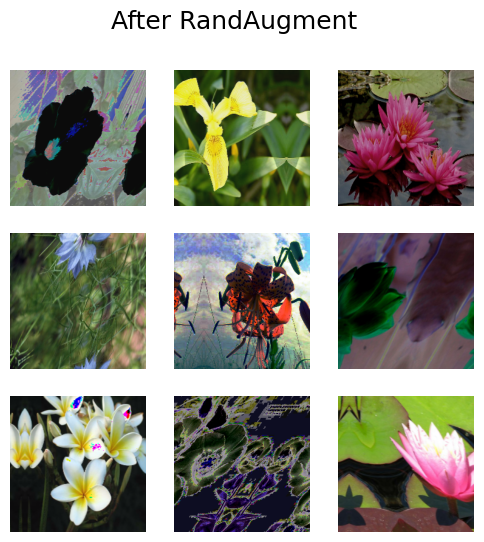

In [8]:
visualize_dataset(train_dataset, title="After RandAugment")

더 다양한 결과를 보려면, `magnitude` 설정을 조정해 보세요.

## CutMix 및 MixUp: 고품질 클래스(inter-class) 간 예제 생성

`CutMix`와 `MixUp`을 사용하면 클래스 간(inter-class) 예제를 생성할 수 있습니다.
`CutMix`는 한 이미지의 일부를 무작위로 잘라내어 다른 이미지 위에 놓고,
`MixUp`은 두 이미지 사이의 픽셀 값을 보간합니다.
이 두 가지 모두 모델이 트레이닝 분포에 과적합되는 것을 방지하고,
모델이 분포 밖 예제로 일반화할 가능성을 높입니다.
또한 `CutMix`는 모델이 분류를 수행하기 위해,
특정 기능에 지나치게 의존하는 것을 방지합니다.
이러한 기술에 대한 자세한 내용은 해당 논문에서 확인할 수 있습니다.

* [CutMix: 강력한 분류기 트레이닝](https://arxiv.org/abs/1905.04899)
* [MixUp: 경험적 위험 최소화를 넘어](https://arxiv.org/abs/1710.09412)

이 예에서는, 수동으로 만든 전처리 파이프라인에서, `CutMix`와 `MixUp`을 독립적으로 사용합니다.
대부분 최신 파이프라인에서 이미지는 `CutMix`, `MixUp` 또는 둘 다 아닌 것으로 무작위로 보강됩니다.
아래 함수는 둘 다 구현합니다.

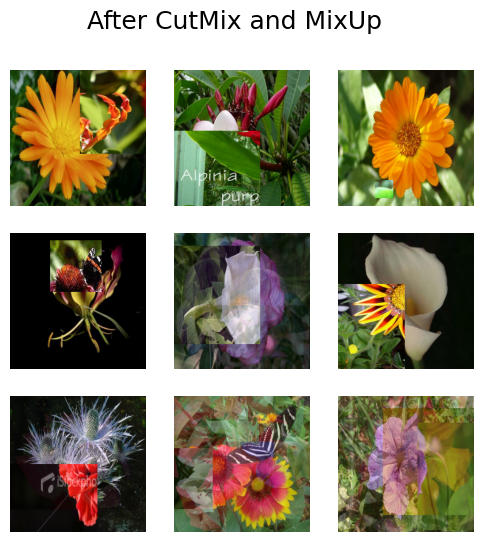

In [9]:
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()


def cut_mix_and_mix_up(samples):
    samples = cut_mix(samples, training=True)
    samples = mix_up(samples, training=True)
    return samples


train_dataset = load_dataset().map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)

visualize_dataset(train_dataset, title="After CutMix and MixUp")

좋습니다! `CutMix`와 `MixUp`을 전처리 파이프라인에 성공적으로 추가한 것 같습니다.

## 보강 파이프라인 커스터마이즈

아마도 `RandAugment`에서 보강을 제외하거나,
기본 `RandAugment` 보강과 함께 옵션으로
[`keras_cv.layers.GridMask`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/layers/augmentation/grid_mask#gridmask-class)를 포함하고 싶을 것입니다.

KerasCV를 사용하면, [`keras_cv.layers.RandomAugmentationPipeline`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/layers/augmentation/random_augmentation_pipeline#randomaugmentationpipeline-class) 레이어를 사용하여, 프로덕션 등급의 커스텀 데이터 보강 파이프라인을 구성할 수 있습니다.
이 클래스는 `RandAugment`와 유사하게 작동합니다.
각 이미지에 적용할 임의의 레이어를 `augmentations_per_image` 번 선택합니다.
`RandAugment`는 `RandomAugmentationPipeline`의 특수 케이스로 생각할 수 있습니다.
사실, 우리의 `RandAugment` 구현은 내부적으로 `RandomAugmentationPipeline`을 상속합니다.

이 예에서, 우리는 표준 `RandAugment` 정책에서 `RandomRotation` 레이어를 제거하고,
그 자리에 `GridMask` 레이어를 대체하여,
커스텀 `RandomAugmentationPipeline`을 만들 것입니다.

첫 번째 단계로, 헬퍼 메서드 `RandAugment.get_standard_policy()`를 사용하여,
베이스 파이프라인을 만들어 보겠습니다.

In [10]:
layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 255), magnitude=0.75, magnitude_stddev=0.3
)

먼저 `RandomRotation` 레이어를 필터링해 보겠습니다.

In [11]:
layers = [
    layer for layer in layers if not isinstance(layer, keras_cv.layers.RandomRotation)
]

다음으로, 레이어에 [`keras_cv.layers.GridMask`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/layers/augmentation/grid_mask#gridmask-class)를 추가해 보겠습니다.

In [12]:
layers = layers + [keras_cv.layers.GridMask()]

마지막으로, 우리는 파이프라인을 구성할 수 있습니다.

In [13]:
pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=layers, augmentations_per_image=3
)


def apply_pipeline(inputs):
    inputs["images"] = pipeline(inputs["images"])
    return inputs


결과를 확인해보죠!

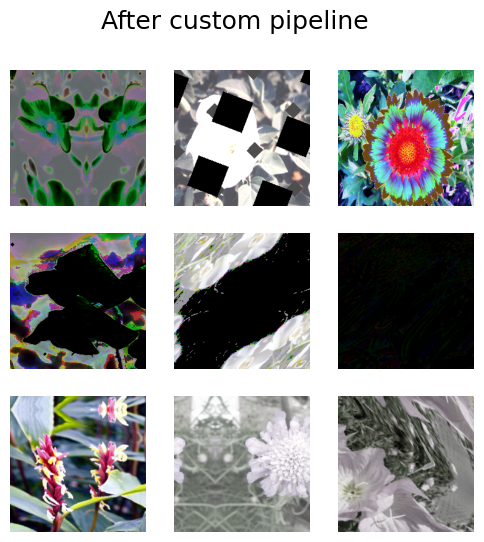

In [14]:
train_dataset = load_dataset().map(apply_pipeline, num_parallel_calls=AUTOTUNE)
visualize_dataset(train_dataset, title="After custom pipeline")

굉장하네요! 보시다시피, 이미지는 무작위로 회전되지 않았습니다.
파이프라인을 원하는 대로 커스터마이즈할 수 있습니다.

In [15]:
pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=[keras_cv.layers.GridMask(), keras_cv.layers.Grayscale(output_channels=3)],
    augmentations_per_image=1,
)

이 파이프라인은 `GrayScale` 또는 GridMask를 적용합니다.

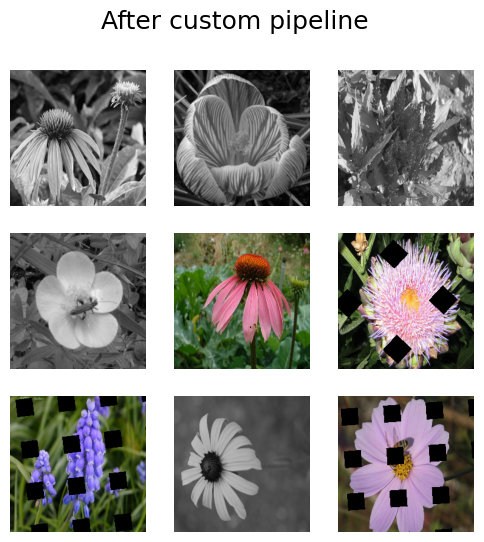

In [16]:

train_dataset = load_dataset().map(apply_pipeline, num_parallel_calls=AUTOTUNE)
visualize_dataset(train_dataset, title="After custom pipeline")

멋지네요! `RandomAugmentationPipeline`을 원하는 대로 사용할 수 있습니다.

## CNN 트레이닝

마지막 연습으로, 이러한 레이어 중 일부를 돌려보겠습니다.
이 섹션에서는 `CutMix`, `MixUp`, `RandAugment`를 사용하여,
Oxford flowers 데이터세트에 대해 최첨단 `ResNet50` 이미지 분류기를 학습합니다.

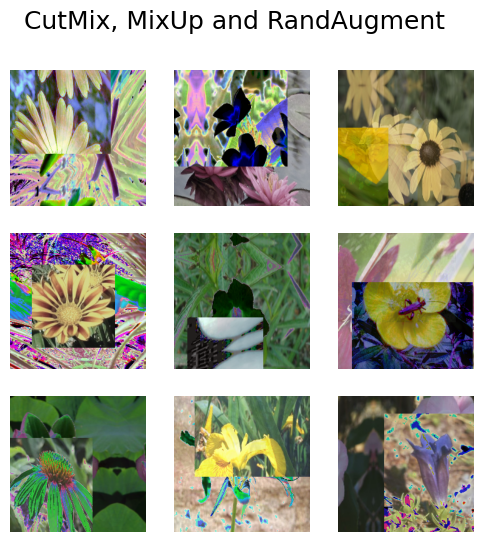

In [17]:

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels


train_dataset = (
    load_dataset()
    .map(apply_rand_augment, num_parallel_calls=AUTOTUNE)
    .map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
)

visualize_dataset(train_dataset, "CutMix, MixUp and RandAugment")

train_dataset = train_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

test_dataset = load_dataset(split="test")
test_dataset = test_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.prefetch(AUTOTUNE)
test_dataset = test_dataset.prefetch(AUTOTUNE)


다음으로 모델 자체를 만들어야 합니다.
손실 함수에서 `label_smoothing=0.1`을 사용한다는 점에 유의하세요.
`MixUp`을 사용할 때는 레이블 스무딩(label smoothing)을 _강력히_ 권장합니다.

In [18]:
input_shape = IMAGE_SIZE + (3,)


def get_model():
    model = keras_cv.models.ImageClassifier.from_preset(
        "efficientnetv2_s", num_classes=num_classes
    )
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=keras.optimizers.SGD(momentum=0.9),
        metrics=["accuracy"],
    )
    return model


마지막으로 모델을 트레이닝합니다.

In [ ]:
model = get_model()
model.fit(
    train_dataset,
    epochs=1,
    validation_data=test_dataset,
)

100%|██████████| 1.78k/1.78k [00:00<00:00, 724kB/s]


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.0088 - loss: 4.7209

## 결론 및 다음 단계

이것이 KerasCV로 최첨단 이미지 보강 파이프라인을 조립하는 데 필요한 모든 것입니다!

독자를 위한 추가 연습으로 다음을 수행할 수 있습니다.

* RandAugment 매개변수에 대한 하이퍼파라미터 검색을 수행하여, 분류기 정확도를 개선합니다.
* Oxford Flowers 데이터 세트를 당신의 고유 데이터 세트로 대체합니다.
* 커스텀 `RandomAugmentationPipeline` 객체로 실험합니다.

현재, Keras 코어와 KerasCV 사이에는 [_28개의 이미지 보강 레이어_](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/layers/preprocessing)가 있습니다!
각각은 독립적으로 또는 파이프라인에서 사용할 수 있습니다.
확인하고 필요한 보강 기술이 누락된 경우,
[KerasCV의 GitHub 이슈](https://github.com/keras-team/keras-cv/issues)를 제출하세요.
